In [14]:
import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import entropy

In [15]:
lsoas = gpd.read_file("./data/lsoa_geo.geojson")

In [16]:
london_data = pd.read_csv("./data/london_lsoa_religion.csv")


In [17]:
lsoa_ward = pd.read_csv("./data/lsoa_ward_2016_lookup.csv")


In [32]:
gdf = lsoas.merge(lsoa_ward, how="right", right_on="LSOA11CD", left_on="lsoa11cd").dropna()

In [33]:
gdf = gdf[gdf["LAD16NM"]=="Tower Hamlets"]
gdf.reset_index(inplace=True, drop=True)
gdf = gdf.merge(london_data, left_on="LSOA11CD", right_on="Codes", how="left")

Index(['geometry', 'lsoa11cd', 'lsoa11nm', 'lsoa11nmw', 'objectid',
       'st_areashape', 'st_lengthshape', 'LSOA11CD', 'LSOA11NM', 'WD16CD',
       'WD16NM', 'LAD16CD', 'LAD16NM', 'FID', 'Codes', 'Names', 'Christian',
       'Buddhist', 'Hindu', 'Jewish', 'Muslim', 'Sikh', 'Other religion',
       'No religion', 'Religion not stated'],
      dtype='object')

In [20]:
gs = gdf["geometry"]

incidence = []

for k, v in gs.iteritems():
    incidence.append(gs.touches(v).as_matrix())

ix = np.stack(incidence, axis=1)

m_incidence = np.zeros(ix.shape)
m_incidence[ix] = 1

In [21]:
m_incidence

array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [22]:
m_incidence.sum()

788.0

In [90]:
# Get weights
dists = gdf[gdf.columns[range(16, 25)]].as_matrix()
dists = dists / dists.sum(axis=1).reshape((144, 1))

# Get pairwise KL-divergence between distributions

# Silly super-wasteful O(n^2) way of doing this
# Figure out something faster for bigger maps

dist_array = dists.tolist()

kl_div = np.zeros((len(gdf), len(gdf)))

for m, elem_m in enumerate(dist_array):
    for n, elem_n in enumerate(dist_array):
        kl_div[m, n] = entropy(elem_m, elem_n)

print(np.unravel_index(kl_div.argmax(), kl_div.shape))
        
# Numpy complains about this elementwise multiplication
# of two identically-shaped matrices for no discernible reason
kl_div = np.multiply(kl_div, m_incidence)

# Take the reciprocal of all extant values
kl_div[~ix] = 1
kl_div = np.reciprocal(kl_div)
kl_div[~ix] = 0

(0, 12)


/home/rikk/anaconda3/envs/geopython/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in multiply


In [82]:
G = nx.from_numpy_matrix(kl_div)

,geometry,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areashape,st_lengthshape,LSOA11CD,LSOA11NM,WD16CD,...,Names,Christian,Buddhist,Hindu,Jewish,Muslim,Sikh,Other religion,No religion,Religion not stated
0,POLYGON ((-0.05274918893657202 51.532625344357...,E01004197,Tower Hamlets 002A,Tower Hamlets 002A,4099,167476.576908,2527.271288,E01004197,Tower Hamlets 002A,E05009331,...,Tower Hamlets 002A,572,39,23,10,614,5,7,517,542
12,POLYGON ((-0.05298703267054404 51.526730290734...,E01004209,Tower Hamlets 011B,Tower Hamlets 011B,4111,82951.440098,1729.444607,E01004209,Tower Hamlets 011B,E05009317,...,Tower Hamlets 011B,197,10,9,8,835,2,0,166,139


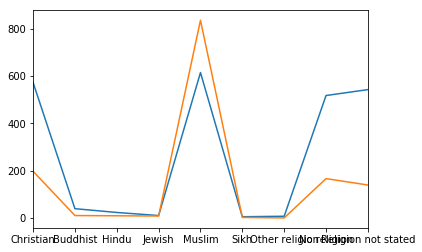

In [97]:
%matplotlib inline
gdf.loc[0, gdf.columns[range(16, 25)]].plot()
gdf.loc[12, gdf.columns[range(16, 25)]].plot()
gdf.loc[[0, 12]]

In [83]:
fiedler = nx.fiedler_vector(G, weight="weight")

In [84]:
f_ix = pd.Series(fiedler)
g1 = gdf[f_ix < 0]
g2 = gdf[f_ix > 0]

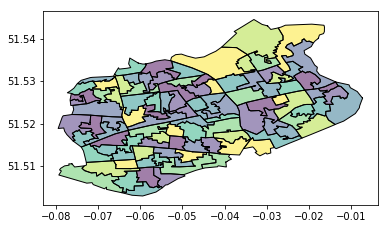

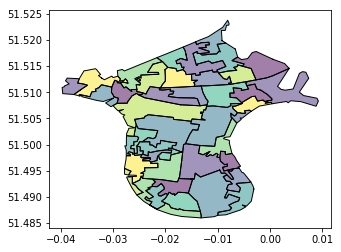

In [85]:
%matplotlib inline
g1.plot()
g2.plot()